In [1]:
import os
import torch
import torchaudio
import torch.optim
from tqdm.notebook import tqdm  # For progress bars in Jupyter Notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
##THIS BLOCK OF CODE IS CHECKING IF CUDA IS WORKING OR NOT 

from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch.optim as optim
import torch.nn as nn

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

# If CUDA is available, print GPU details
if cuda_available:
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected by PyTorch.")

CUDA Available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
##############LOADING AUDIO FILES AND PREPROCESSING###############
#####USED TORCHAUDIO FOR LOADING THE LIBRARIES
####SAMPLE RATE= 160000(16khz) COMMONLY CHOSEN

def load_audio_nfiles(directory, sample_rate=16000):
    """

    Args:
        directory (str): Path to the directory containing .wav files.
        sample_rate (int, optional): Target sample rate for audio files. Defaults to 16000.

    Returns:
        Tuple[List[np.ndarray], List[str]]: A tuple containing a list of audio waveforms and their file names.
    """
    audio_waveforms = []
    file_names = []
    
    # List all .wav files in the directory
    file_list = [f for f in os.listdir(directory) if f.lower().endswith('.wav')]
    
    if not file_list:
        raise ValueError(f"No .wav files found in the directory: {directory}")
    ## tdqm is the library used fro visual progress bars 
    # Use tqdm for progress tracking
    for file_name in tqdm(file_list, desc="Loading audio files"):
        file_path = os.path.join(directory, file_name)#to construct the full path by coming direcotory path and file name
        try:
            waveform, sr = torchaudio.load(file_path)#torchaudio is used to load audio into the memory
            ##resampling is happening here to standardize the audio data ensuring consistent inputs
            if sr != sample_rate:
                resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                waveform = resample(waveform)
                #audio data might have extra channel dimension,especially when audio is sterio
                #sqeeze() : removes the dimension . Converts tensor shape from (1,N) to (N)
            waveform = waveform.squeeze()  # Remove channel dimension if it's mono
              #Processsed wavform is converted into NumPy array and stored in file_names
            audio_waveforms.append(waveform.numpy())  # Convert to numpy array
            file_names.append(file_name)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    
    return audio_waveforms, file_names

# Example usage
directory =  "C:/Users/prann/OneDrive/Desktop/UPES/7th sem/emotion-detection/data" 
audio_waveforms, file_names = load_audio_nfiles(directory)
print(f"Loaded {len(audio_waveforms)} audio files.")


In [4]:
############EXTRACTING LABELS FROM FILENAMES##############
##the function here returns the labels which are extracted from the file names

def extract_labels(file_names):
    """
    Extract emotion labels from file names.d

    Args:
        file_names (List[str]): List of audio file names.

    Returns:
        List[str]: List of extracted emotion labels.
    """
    emotions = []#initializing an empty list 
    for file_name in file_names:
        # Assuming the file name format is OAF_Word_emotion.wav
        parts = file_name.split('_')#splits each file using underscore(_) as delimeter 
        #3 is used to check whether file name follows the format or not
        if len(parts) >= 3:
            emotion_part = parts[-1]#-1is used since negative indexing allows you to access elements from the end list
            #part[-1]is expected to contain emotion along with file extension that is the lasrt elemarnt 
            emotion = emotion_part.split('.')[0]  # Remove the file extension
            emotions.append(emotion)
        else:
            emotions.append('unknown')  # Handle unexpected file name formats
    return emotions

# Extract emotion labels
emotion_labels = extract_labels(file_names)
print(f"Extracted emotion labels for {len(emotion_labels)} audio files.")

# Initialize LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(emotion_labels)

# For reference, get the mapping of labels to integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Extracted emotion labels for 2800 audio files.
Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'ps': 5, 'sad': 6}


In [5]:
#Wav2Vec2Processor and Wav2Vec2Model are part of the Hugging Face Transformers library, designed for speech processing tasks.
#from_pretrained: This method loads a pre-trained Wav2Vec 2.0 model and its corresponding processor from the Hugging Face model hub. In this case, the model facebook/wav2vec2-base is used, which has been trained on large amounts of speech data.
#Wav2Vec2Processor handles processing the input audio (waveforms) into a format that the model can use.
#Wav2Vec2Model is the core model that extracts features from audio input. This model produces rich embeddings from raw audio signals, which can be used for downstream tasks such as emotion detection.

#Gradient checkpointing is memory saving technique used in deep learning to reduce GPU memory usage training 


#outputs.last_hidden_state: These are the audio features (embeddings) extracted by the Wav2Vec2 model. They are 3D tensors of shape (batch_size, sequence_length, feature_size), where the sequence length corresponds to the length of the audio input.
#mean(dim=1): Since we are interested in summarizing the features, we take the mean across the time dimension (dimension 1), producing a 2D tensor of shape (batch_size, feature_size). This gives us a compact representation of the audio features.
#.cpu().numpy(): The result is moved back to the CPU (if it was on the GPU) and converted to a NumPy array, making it easier to work with later.

In [6]:
#############Wave2Vec2 FEATURE EXTRACTION
 #  Used Wav2Vec2 model to extract features from the audio waveforms.
 # Wav2Vec2 is a pre-trained model that converts audio data into meaningful features,which are more informative for downstream tasks like emotion classification.

# Initialize Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")#converts audio wavforms into features
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")#Pre-trained Wav2Vec2 model for extracting features.

# Enable gradient checkpointing for the model (it is optional since it is only for reducing the memory usage of GPU
wav2vec_model.gradient_checkpointing_enable()#Reduces memory usage during training.



###########to check whether cuda is available or not
# Move model to appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wav2vec_model.to(device)
print(f"Using device: {device}")
############################################




###PROCESSES THE AUDIO WAVFORM AND EXTRACT  FEATURES USING Wav2Vec2 MODEL
def extract_wav2vec_features(audio_waveforms):
    features = []
    #here again tdqm is used to view the progresss bar to track the progress
    for waveform in tqdm(audio_waveforms, desc="Extracting Wav2Vec2 features"):
        #Processor converts each wavform into format moddel expects.It also pad the wavforms and ensures the sample rate matches expected 16000Hz
        inputs = processor(waveform, return_tensors="pt", padding=True, sampling_rate=16000)
        #all the input tensors are moved to the GPU
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move to GPU if available
        with torch.no_grad():
            outputs = wav2vec_model(**inputs)
        features.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())  # Extract mean feature across time
    return features

# Extract features using Wav2Vec2
audio_features = extract_wav2vec_features(audio_waveforms)
audio_features = torch.tensor(audio_features)#features to be used in subsequent machine learning tasks, such as classification or regression.
print(f"Extracted Wav2Vec2 features shape: {audio_features.shape}")


C:\Users\prann\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
C:\Users\prann\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_emb

Using device: cuda


Extracting Wav2Vec2 features:   0%|          | 0/2800 [00:00<?, ?it/s]

C:\Users\prann\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:862: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Extracted Wav2Vec2 features shape: torch.Size([2800, 1, 768])


C:\Users\prann\AppData\Local\Temp\ipykernel_7480\1802177933.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  audio_features = torch.tensor(audio_features)#features to be used in subsequent machine learning tasks, such as classification or regression.


In [7]:
#####################TRAIN -TEST SPLIT


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    audio_features.cpu().numpy(),  # Use the converted numpy array
    encoded_labels,                # Ensure that encoded_labels is defined
    test_size=0.1,                 # Use 10% of the data for testing
    random_state=42,
    stratify=encoded_labels         # Ensure class proportions are maintained
)

#X_train.shape[0]: This retrieves the number of rows (samples) in the training set.
#X_test.shape[0]: This retrieves the number of rows (samples) in the test set.
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Convert data back to tensors and ensure they are on the correct device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

################ Create datasets and loaders
from torch.utils.data import TensorDataset, DataLoader
#PyTorch's TensorDataset class consolidates input and target data into a single dataset, facilitating easy access to both features and labels during training or testing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#batch size 16 is chossen since it is typically a good default help in balancing between computational efficiency and memory constraints
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Training samples: 2520, Testing samples: 280


In [8]:
from tqdm import tqdm  # For progress bars

def train(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [9]:
import torch.optim as optim  # Importing the optimizer
import torch.nn as nn  # Importing necessary modules for neural networks, layer of neural network
##for simple feed forward neural network
##mAPS Wav2Vec features to emtotion labels usin fully connected layers
# Define the EmotionClassifier model class if not already defined
class EmotionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),# Input to hidden layer with 128 neurons
            nn.ReLU(), # Activation function (ReLU)
            nn.Dropout(0.3), # Dropout to reduce overfitting (30% neurons dropped)
            nn.Linear(128, 64), # Hidden to another hidden layer with 64 neurons
            nn.ReLU(), # Activation function (ReLU)
            nn.Dropout(0.3),# randomly drops neurons during training to prevent overfitting and improve model generalization.
            nn.Linear(64, num_classes) # Final output layer (num_classes is the number of emotion classes)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)# Reshape the input to a 2D tensor (batch_size, features)
        return self.fc(x)# Pass the input through the sequentially defined layers
        ##defined layers sequence linear layer-> ReLu -> Dropout

# Assuming audio_features and label_encoder are already defined from previous code
input_size = audio_features.shape[-1]  # Feature size from Wav2Vec2 features
num_classes = len(label_encoder.classes_)  # Number of classes (emotions)

# Instantiate the model
model = EmotionClassifier(input_size=input_size, num_classes=num_classes)
model.to(device)  # Move model to the correct device (GPU or CPU)

# Define the loss function
'''CrossEntropyLoss: This is a loss function commonly used for classification problems. It combines softmax and negative
log-likelihood to measure the error between the predicted and actual class probabilities.'''
criterion = nn.CrossEntropyLoss()

# Learning rate tuning
learning_rates = [1e-3, 1e-4, 1e-5]  # Different learning rates to test
best_acc = 0
best_lr = 0

'''
Optimizer setup: The code initializes the Adam optimizer for each learning rate.
Training: Calls a train function (assumed to be defined elsewhere) to train the model for 10 epochs with the current learning rate.
Evaluation: Calls an evaluate function (also assumed to be defined) to evaluate the model’s accuracy on the test set.
Best accuracy tracking: The code tracks the highest accuracy (best_acc) and stores the corresponding learning rate (best_lr).'''
for lr in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Initialize the optimizer with the current learning rate
    print(f"Training with learning rate: {lr}")
    
    # Train the model for the specified number of epochs
    train(model, train_loader, criterion, optimizer, device, epochs=50)
    
    # Evaluate the model on the test set
    acc = evaluate(model, test_loader, device)
    
    # Track the best accuracy and corresponding learning rate
    if acc > best_acc:
        best_acc = acc
        best_lr = lr

# Output the best learning rate and accuracy
print(f"Best learning rate: {best_lr}, Accuracy: {best_acc}%")


Training with learning rate: 0.001


Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 211.12it/s]


Epoch [1/50], Loss: 1.7288


Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 404.41it/s]


Epoch [2/50], Loss: 1.0125


Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 407.09it/s]


Epoch [3/50], Loss: 0.6324


Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 349.28it/s]


Epoch [4/50], Loss: 0.4389


Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 339.46it/s]


Epoch [5/50], Loss: 0.3739


Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 313.66it/s]


Epoch [6/50], Loss: 0.2949


Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 359.09it/s]


Epoch [7/50], Loss: 0.2609


Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 370.30it/s]


Epoch [8/50], Loss: 0.2338


Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 326.02it/s]


Epoch [9/50], Loss: 0.2016


Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 345.52it/s]


Epoch [10/50], Loss: 0.1710


Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 330.09it/s]


Epoch [11/50], Loss: 0.1674


Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 325.55it/s]


Epoch [12/50], Loss: 0.1591


Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 336.41it/s]


Epoch [13/50], Loss: 0.1373


Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 347.10it/s]


Epoch [14/50], Loss: 0.1332


Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 344.90it/s]


Epoch [15/50], Loss: 0.1198


Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 263.95it/s]


Epoch [16/50], Loss: 0.1125


Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 323.35it/s]


Epoch [17/50], Loss: 0.1135


Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 340.03it/s]


Epoch [18/50], Loss: 0.0886


Epoch 19/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 325.23it/s]


Epoch [19/50], Loss: 0.0850


Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 341.14it/s]


Epoch [20/50], Loss: 0.0888


Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 344.85it/s]


Epoch [21/50], Loss: 0.0877


Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 351.55it/s]


Epoch [22/50], Loss: 0.0697


Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 361.61it/s]


Epoch [23/50], Loss: 0.0847


Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 336.45it/s]


Epoch [24/50], Loss: 0.0701


Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 352.34it/s]


Epoch [25/50], Loss: 0.0685


Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 326.05it/s]


Epoch [26/50], Loss: 0.0665


Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 360.73it/s]


Epoch [27/50], Loss: 0.0621


Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 343.01it/s]


Epoch [28/50], Loss: 0.0749


Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 333.58it/s]


Epoch [29/50], Loss: 0.0690


Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 347.13it/s]


Epoch [30/50], Loss: 0.0690


Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 333.59it/s]


Epoch [31/50], Loss: 0.0474


Epoch 32/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 340.13it/s]


Epoch [32/50], Loss: 0.0632


Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 352.60it/s]


Epoch [33/50], Loss: 0.0558


Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 342.41it/s]


Epoch [34/50], Loss: 0.0555


Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 359.80it/s]


Epoch [35/50], Loss: 0.0546


Epoch 36/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 334.92it/s]


Epoch [36/50], Loss: 0.0513


Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 356.80it/s]


Epoch [37/50], Loss: 0.0556


Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 347.75it/s]


Epoch [38/50], Loss: 0.0683


Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 337.33it/s]


Epoch [39/50], Loss: 0.0444


Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 385.26it/s]


Epoch [40/50], Loss: 0.0548


Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 405.47it/s]


Epoch [41/50], Loss: 0.0681


Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 372.64it/s]


Epoch [42/50], Loss: 0.0571


Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 401.73it/s]


Epoch [43/50], Loss: 0.0596


Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 380.65it/s]


Epoch [44/50], Loss: 0.0491


Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 405.37it/s]


Epoch [45/50], Loss: 0.0385


Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 405.79it/s]


Epoch [46/50], Loss: 0.0423


Epoch 47/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 378.83it/s]


Epoch [47/50], Loss: 0.0464


Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 410.45it/s]


Epoch [48/50], Loss: 0.0476


Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 389.97it/s]


Epoch [49/50], Loss: 0.0462


Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 362.43it/s]


Epoch [50/50], Loss: 0.0459


NameError: name 'evaluate' is not defined

In [10]:
#########MEASURE THE PERFORMANCE OF TRAINED MODEL
def evaluate(model, test_loader, device):
    model.eval()#it enables certain layers like dropout and batch normalization
    correct = 0
    total = 0
    with torch.no_grad():#seful for inference because it saves memory and computation time by not tracking gradients, which are only needed during training for backpropagation.
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)#outputs represent the predicted scores for each class.
            _, predicted = torch.max(outputs, 1)#here 1 specifies that the operation is performed along the class dimension
            total += labels.size(0)#tracks the total number of samples evaluated, which is incremented by the batch size
            correct += (predicted == labels).sum().item()#sums how many predictions were correct 
    #percentage of correct predictions out of the total predictions made
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate(model, test_loader, device)


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 207.95it/s]

Test Accuracy: 98.93%


In [ ]:
# model: The neural network model.
# train_loader: DataLoader for the training data.
# test_loader: DataLoader for the validation data.
# criterion: The loss function (e.g., CrossEntropyLoss).
# optimizer: Optimizer to update the model’s parameters (e.g., Adam).
# device: GPU or CPU where the computations will take place.
# epochs: The number of training iterations over the entire dataset (default is 10).

Epoch [1/115], Training Loss: 0.0399, Validation Loss: 0.0105
Epoch [2/115], Training Loss: 0.0241, Validation Loss: 0.0069
Epoch [3/115], Training Loss: 0.0145, Validation Loss: 0.0080
Epoch [4/115], Training Loss: 0.0164, Validation Loss: 0.0095
Epoch [5/115], Training Loss: 0.0148, Validation Loss: 0.0073
Epoch [6/115], Training Loss: 0.0102, Validation Loss: 0.0075
Epoch [7/115], Training Loss: 0.0133, Validation Loss: 0.0087
Epoch [8/115], Training Loss: 0.0125, Validation Loss: 0.0096
Epoch [9/115], Training Loss: 0.0147, Validation Loss: 0.0084
Epoch [10/115], Training Loss: 0.0131, Validation Loss: 0.0089
Epoch [11/115], Training Loss: 0.0101, Validation Loss: 0.0081
Epoch [12/115], Training Loss: 0.0119, Validation Loss: 0.0079
Epoch [13/115], Training Loss: 0.0152, Validation Loss: 0.0092
Epoch [14/115], Training Loss: 0.0119, Validation Loss: 0.0105
Epoch [15/115], Training Loss: 0.0109, Validation Loss: 0.0088
Epoch [16/115], Training Loss: 0.0139, Validation Loss: 0.0088
E

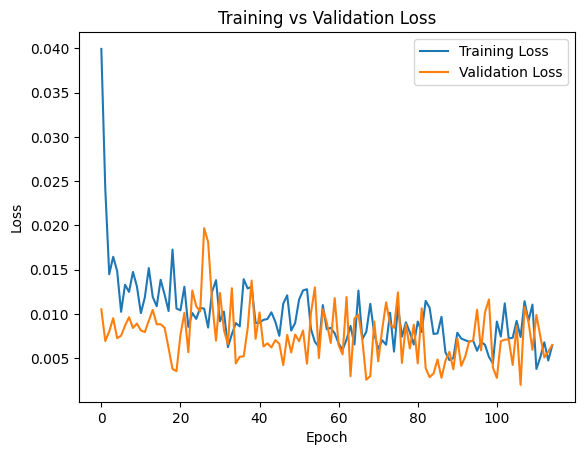

In [11]:
##############TO TRACK THE LOSS HISTORY DURING TRAINING AND VALIDATION
import matplotlib.pyplot as plt
# Function to train the model and track loss history for both training and validation
def train_and_track_loss(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    train_loss_history = []
    val_loss_history = []
    #loop through the number of epochs (default :10)
    for epoch in range(epochs):
         # Set the model to training mode to enable gradient computation and dropout
        model.train()
        running_loss = 0.0 # Accumulates the total loss for the current epoch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)

        # Validation Loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(test_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    return train_loss_history, val_loss_history

#  Optimizer: Using Adam optimizer with a reduced learning rate of 1e-4 for stable training
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Reduced learning rate

# Train and plot the loss history
train_loss_history, val_loss_history = train_and_track_loss(model, train_loader, test_loader, criterion, optimizer, device, epochs=115)
#model,  # The model to train
    #train_loader,  # DataLoader for training data
    #test_loader,  # DataLoader for validation data
    #criterion,  # Loss function (e.g., CrossEntropyLoss)
    #optimizer,  # Optimizer (e.g., Adam)
    #device,  # Device (CPU or GPU)
    #epochs=115  # Number of training epochs
#plot the training and validation over epochs to visualize learning
plt.plot(train_loss_history, label='Training Loss')#training loss curve 
plt.plot(val_loss_history, label='Validation Loss')#validation loss curve
plt.xlabel('Epoch')#label for x-axis
plt.ylabel('Loss')#label for y-axis
plt.title('Training vs Validation Loss')#title of the plot
plt.legend()#display the legend
plt.show()#show the plot


In [12]:
###########SAVING THE MODEL###############
# Save the model's state dictionary
torch.save(model.state_dict(), 'emotion_classifier.pth')
print("Model saved successfully.")


Model saved successfully.


In [20]:
########################LOADING THE MODEL
# Load the model's state dictionary
loaded_model = EmotionClassifier(input_size=input_size, num_classes=num_classes)
loaded_model.load_state_dict(torch.load('emotion_classifier.pth'))
loaded_model.to(device)
loaded_model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")


Model loaded successfully.


C:\Users\prann\AppData\Local\Temp\ipykernel_7480\140815269.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('emotion_classifier.pt

In [21]:
#######MODEL SAVING AND LOADING 

#delpoy model 
# Save the trained model
torch.save(model.state_dict(), 'emotion_classifier.pth')

# To load it back
model = EmotionClassifier(input_size=audio_features.shape[-1], num_classes=len(label_encoder.classes_))
model.load_state_dict(torch.load('emotion_classifier.pth'))
model.eval()


C:\Users\prann\AppData\Local\Temp\ipykernel_7480\411766794.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('emotion_classifier.pth'))


EmotionClassifier(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=7, bias=True)
  )
)

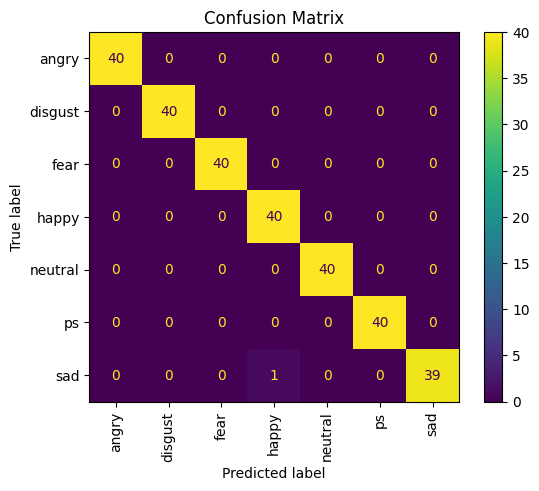

In [25]:
#############CONFUSION MATRIX FOR DETAILED EVALUATION
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure tensors and model are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the correct device

# Get true and predicted labels
y_true = y_test_tensor.cpu().numpy()  # Convert true labels to numpy (for sklearn compatibility)
y_pred = []

# Get predictions for the test set
with torch.no_grad():
    for inputs in X_test_tensor:
        inputs = inputs.to(device)  # Move inputs to the same device as the model
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension with unsqueeze
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        y_pred.append(predicted.item())  # Append the prediction

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot confusion matrix
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()




In [26]:
import torchaudio.transforms as T  # Import torchaudio transformations for audio augmentation
import torch  # Import PyTorch

# Define transformations for audio augmentation
spectrogram_transform = T.Spectrogram(n_fft=400)  
# Creates a spectrogram from a waveform. 'n_fft=400' defines the size of the FFT (Fast Fourier Transform) window.
# A smaller n_fft provides better temporal resolution, while a larger n_fft provides better frequency resolution.

time_stretch = T.TimeStretch(n_freq=201, fixed_rate=1.2)  
# Stretches the audio signal without changing its pitch. 'n_freq=201' corresponds to the number of frequency bins, 
# and 'fixed_rate=1.2' means the audio duration will be stretched by 20%.

pitch_shift = T.PitchShift(sample_rate=16000, n_steps=2)  
# Shifts the pitch of the audio without changing its duration. 'sample_rate=16000' ensures the operation is based on the correct sampling rate.
# 'n_steps=2' means the pitch is shifted by two semitones.

add_noise = lambda x: x + 0.005 * torch.randn_like(x)  
# Adds Gaussian noise to the audio. 'torch.randn_like(x)' generates random noise with the same shape as the input waveform.
# '0.005' is the noise intensity; this small value ensures the noise doesn't overpower the original signal.

# Apply augmentations to audio waveforms
augmented_waveforms = []  # List to store the augmented waveforms
for waveform in audio_waveforms:  # Loop over each waveform in the dataset
    # Convert NumPy array to PyTorch tensor
    waveform_tensor = torch.tensor(waveform, dtype=torch.float32)  
    # Converts the waveform (initially a NumPy array) to a PyTorch tensor for compatibility with PyTorch operations.

    # Convert waveform to spectrogram (required for TimeStretch)
    spectrogram = spectrogram_transform(waveform_tensor.unsqueeze(0))  
    # Converts the 1D waveform into a 2D spectrogram. 'unsqueeze(0)' adds a batch dimension since the transform expects a 2D input.

    # TimeStretch requires complex tensor; convert spectrogram to complex
    spectrogram_complex = torch.complex(spectrogram, torch.zeros_like(spectrogram))  
    # TimeStretch requires the spectrogram to have complex values. This step converts the spectrogram into a complex tensor
    # by combining the real part (spectrogram) with an imaginary part initialized to zeros.

    # Apply TimeStretch
    stretched_spectrogram = time_stretch(spectrogram_complex)  
    # Stretches the spectrogram using the defined 'time_stretch' transformation.

    # Convert back to waveform using PyTorch's istft
    waveform_stretched = torch.istft(
        stretched_spectrogram, n_fft=400, hop_length=200, length=waveform_tensor.size(0)
    )
    # Converts the stretched spectrogram back to a waveform using the Inverse Short-Time Fourier Transform (ISTFT).
    # 'n_fft=400' matches the FFT size used earlier. 'hop_length=200' defines the overlap between consecutive frames.
    # 'length=waveform_tensor.size(0)' ensures the output waveform has the same length as the original.

    # Apply pitch shift
    waveform_pitched = pitch_shift(waveform_tensor.unsqueeze(0)).squeeze(0)  
    # Applies pitch shifting to the waveform. 'unsqueeze(0)' adds a batch dimension for compatibility with the transform,
    # and 'squeeze(0)' removes the batch dimension after processing.

    # Apply noise
    waveform_noisy = add_noise(waveform_tensor)  
    # Adds Gaussian noise to the waveform using the previously defined lambda function.

    # Collect augmented waveforms
    augmented_waveforms.extend([waveform_stretched, waveform_pitched, waveform_noisy])  
    # Adds the augmented waveforms (stretched, pitch-shifted, and noisy) to the list of augmented waveforms.

# Print the number of original and augmented waveforms
print(f"Original waveforms: {len(audio_waveforms)}, Augmented waveforms: {len(augmented_waveforms)}")
# Outputs the total count of original and augmented waveforms for verification

C:\Users\prann\AppData\Local\Temp\ipykernel_7480\1491864658.py:28: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\SpectralOps.cpp:1028.)
  waveform_stretched = torch.istft(
C:\Users\prann\AppData\Local\Temp\ipykernel_7480\1491864658.py:28: UserWarning: The length of signal is shorter than the length parameter. Result is being padded with zeros in the tail. Please check your center and hop_length settings. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\SpectralOps.cpp:1190.)
  waveform_stretched = torch.istft(


Original waveforms: 2800, Augmented waveforms: 8400


In [28]:
#############FINE TUNING
def train_finetune(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Prepare inputs for Wav2Vec2 model
            waveforms = waveforms.to(device)  # Move waveforms to the correct device
            inputs = processor(waveforms, return_tensors="pt", padding=True, sampling_rate=16000)
            inputs = {key: val.squeeze(1).to(device) for key, val in inputs.items()}  # Remove extra dimension

            labels = labels.to(device)  # Move labels to the correct device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits  # Extract classification logits

            # Compute loss
            loss = criterion(logits, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [29]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(audio_features, encoded_labels)):
    print(f"Fold {fold + 1}")
    X_train, X_val = audio_features[train_idx], audio_features[val_idx]
    y_train, y_val = encoded_labels[train_idx], encoded_labels[val_idx]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=batch_size)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=batch_size)

    # Train and evaluate for each fold
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    evaluate(model, val_loader, device)


C:\Users\prann\AppData\Local\Temp\ipykernel_7480\682423064.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=batch_size)
C:\Users\prann\AppData\Local\Temp\ipykernel_7480\682423064.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=batch_size)


Fold 1


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 277.24it/s]


Epoch [1/10], Loss: 0.0092


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 438.29it/s]


Epoch [2/10], Loss: 0.0130


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 554.80it/s]


Epoch [3/10], Loss: 0.0089


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 586.64it/s]


Epoch [4/10], Loss: 0.0111


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 571.45it/s]


Epoch [5/10], Loss: 0.0066


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 576.78it/s]


Epoch [6/10], Loss: 0.0090


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 523.31it/s]


Epoch [7/10], Loss: 0.0097


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 582.66it/s]


Epoch [8/10], Loss: 0.0052


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 575.26it/s]


Epoch [9/10], Loss: 0.0076


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 588.99it/s]


Epoch [10/10], Loss: 0.0088


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 879.71it/s]


Test Accuracy: 100.00%
Fold 2


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 458.60it/s]


Epoch [1/10], Loss: 0.0066


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 570.68it/s]


Epoch [2/10], Loss: 0.0034


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 565.78it/s]


Epoch [3/10], Loss: 0.0076


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 571.97it/s]


Epoch [4/10], Loss: 0.0097


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 581.89it/s]


Epoch [5/10], Loss: 0.0059


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 532.84it/s]


Epoch [6/10], Loss: 0.0078


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 568.82it/s]


Epoch [7/10], Loss: 0.0075


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 574.73it/s]


Epoch [8/10], Loss: 0.0085


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 566.70it/s]


Epoch [9/10], Loss: 0.0121


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 545.69it/s]


Epoch [10/10], Loss: 0.0088


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 618.75it/s]


Test Accuracy: 100.00%
Fold 3


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 488.31it/s]


Epoch [1/10], Loss: 0.0076


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 570.24it/s]


Epoch [2/10], Loss: 0.0091


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 574.53it/s]


Epoch [3/10], Loss: 0.0088


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 579.01it/s]


Epoch [4/10], Loss: 0.0072


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 553.55it/s]


Epoch [5/10], Loss: 0.0123


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 580.38it/s]


Epoch [6/10], Loss: 0.0078


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 579.51it/s]


Epoch [7/10], Loss: 0.0098


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 583.64it/s]


Epoch [8/10], Loss: 0.0106


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 554.63it/s]


Epoch [9/10], Loss: 0.0051


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 592.02it/s]


Epoch [10/10], Loss: 0.0064


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1043.92it/s]


Test Accuracy: 100.00%
Fold 4


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 519.75it/s]


Epoch [1/10], Loss: 0.0090


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 579.81it/s]


Epoch [2/10], Loss: 0.0115


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 583.01it/s]


Epoch [3/10], Loss: 0.0106


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 547.19it/s]


Epoch [4/10], Loss: 0.0083


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 576.93it/s]


Epoch [5/10], Loss: 0.0123


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 582.73it/s]


Epoch [6/10], Loss: 0.0072


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 588.89it/s]


Epoch [7/10], Loss: 0.0087


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 537.39it/s]


Epoch [8/10], Loss: 0.0081


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 560.06it/s]


Epoch [9/10], Loss: 0.0086


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 581.09it/s]


Epoch [10/10], Loss: 0.0090


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1075.65it/s]


Test Accuracy: 99.82%
Fold 5


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 504.42it/s]


Epoch [1/10], Loss: 0.0114


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 578.97it/s]


Epoch [2/10], Loss: 0.0114


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 538.12it/s]


Epoch [3/10], Loss: 0.0099


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 587.58it/s]


Epoch [4/10], Loss: 0.0110


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 584.51it/s]


Epoch [5/10], Loss: 0.0102


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 585.20it/s]


Epoch [6/10], Loss: 0.0068


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 545.50it/s]


Epoch [7/10], Loss: 0.0097


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 577.30it/s]


Epoch [8/10], Loss: 0.0087


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 583.12it/s]


Epoch [9/10], Loss: 0.0108


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 578.82it/s]


Epoch [10/10], Loss: 0.0068


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1022.79it/s]

Test Accuracy: 100.00%


In [30]:
##############CROSS VALIDATION(K-fold cross validation)
from sklearn.model_selection import StratifiedKFold
# Initialize Stratified K-Fold with 5 splits to maintain class balance in each fold
kf = StratifiedKFold(n_splits=5)
# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(audio_features, encoded_labels)):
    print(f"Fold {fold + 1}")
    # Split the data into training and validation sets for this fold
    X_train, X_val = audio_features[train_idx], audio_features[val_idx]
    y_train, y_val = encoded_labels[train_idx], encoded_labels[val_idx]
# Create DataLoaders for training and validation datasets
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=batch_size)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=batch_size)

    # Train and evaluate for each fold
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    evaluate(model, val_loader, device)


C:\Users\prann\AppData\Local\Temp\ipykernel_7480\3490862149.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=batch_size)
C:\Users\prann\AppData\Local\Temp\ipykernel_7480\3490862149.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=batch_size)


Fold 1


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 352.82it/s]


Epoch [1/10], Loss: 0.0095


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 576.49it/s]


Epoch [2/10], Loss: 0.0071


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 535.21it/s]


Epoch [3/10], Loss: 0.0121


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 444.38it/s]


Epoch [4/10], Loss: 0.0068


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 530.31it/s]


Epoch [5/10], Loss: 0.0084


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 576.02it/s]


Epoch [6/10], Loss: 0.0085


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 585.84it/s]


Epoch [7/10], Loss: 0.0072


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 579.40it/s]


Epoch [8/10], Loss: 0.0075


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 572.61it/s]


Epoch [9/10], Loss: 0.0131


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 518.21it/s]


Epoch [10/10], Loss: 0.0058


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 939.89it/s]


Test Accuracy: 100.00%
Fold 2


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 501.94it/s]


Epoch [1/10], Loss: 0.0087


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 497.57it/s]


Epoch [2/10], Loss: 0.0085


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 482.42it/s]


Epoch [3/10], Loss: 0.0070


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 507.35it/s]


Epoch [4/10], Loss: 0.0110


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 570.32it/s]


Epoch [5/10], Loss: 0.0075


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 573.63it/s]


Epoch [6/10], Loss: 0.0062


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 561.98it/s]


Epoch [7/10], Loss: 0.0082


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 514.88it/s]


Epoch [8/10], Loss: 0.0058


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 569.62it/s]


Epoch [9/10], Loss: 0.0114


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 569.04it/s]


Epoch [10/10], Loss: 0.0085


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 923.76it/s]


Test Accuracy: 100.00%
Fold 3


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 498.72it/s]


Epoch [1/10], Loss: 0.0069


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 535.26it/s]


Epoch [2/10], Loss: 0.0102


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 451.63it/s]


Epoch [3/10], Loss: 0.0099


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 583.96it/s]


Epoch [4/10], Loss: 0.0135


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 580.16it/s]


Epoch [5/10], Loss: 0.0130


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 585.97it/s]


Epoch [6/10], Loss: 0.0061


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 548.55it/s]


Epoch [7/10], Loss: 0.0069


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 556.21it/s]


Epoch [8/10], Loss: 0.0116


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 549.88it/s]


Epoch [9/10], Loss: 0.0097


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 536.63it/s]


Epoch [10/10], Loss: 0.0106


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 979.82it/s]


Test Accuracy: 100.00%
Fold 4


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 434.70it/s]


Epoch [1/10], Loss: 0.0063


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 493.68it/s]


Epoch [2/10], Loss: 0.0067


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 509.58it/s]


Epoch [3/10], Loss: 0.0062


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 496.24it/s]


Epoch [4/10], Loss: 0.0059


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 478.20it/s]


Epoch [5/10], Loss: 0.0099


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 537.59it/s]


Epoch [6/10], Loss: 0.0071


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 525.34it/s]


Epoch [7/10], Loss: 0.0126


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 500.30it/s]


Epoch [8/10], Loss: 0.0077


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 503.99it/s]


Epoch [9/10], Loss: 0.0103


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 572.36it/s]


Epoch [10/10], Loss: 0.0112


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 1074.94it/s]


Test Accuracy: 99.82%
Fold 5


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 457.78it/s]


Epoch [1/10], Loss: 0.0146


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 575.75it/s]


Epoch [2/10], Loss: 0.0092


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 531.72it/s]


Epoch [3/10], Loss: 0.0096


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 578.21it/s]


Epoch [4/10], Loss: 0.0092


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 573.45it/s]


Epoch [5/10], Loss: 0.0179


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 543.01it/s]


Epoch [6/10], Loss: 0.0127


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 558.08it/s]


Epoch [7/10], Loss: 0.0080


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 500.37it/s]


Epoch [8/10], Loss: 0.0116


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 544.72it/s]


Epoch [9/10], Loss: 0.0157


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 438.82it/s]


Epoch [10/10], Loss: 0.0119


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 998.53it/s]

Test Accuracy: 100.00%


In [31]:
##########DEPLOY THE MODEL
from flask import Flask, request, jsonify  # Import Flask for creating an API, request for handling HTTP requests, jsonify for JSON responses
import torch  # Import PyTorch for loading and running the trained model

# Initialize the Flask app
app = Flask(__name__)  # `__name__` specifies the name of the current module, used to initialize Flask application

# Load the trained model
model = EmotionClassifier(input_size=input_size, num_classes=num_classes)  # Instantiate the EmotionClassifier model with input size and number of emotion classes
model.load_state_dict(torch.load('emotion_classifier.pth'))  # Load the trained model weights from the saved file
model.eval()  # Set the model to evaluation mode (important for inference)

# Define an API endpoint for emotion prediction
@app.route('/predict', methods=['POST'])  # Create a route `/predict` that accepts only POST requests
def predict():
    data = request.json  # Extract JSON data from the POST request (assuming the audio waveform is sent in the body of the request)
    waveform = torch.tensor(data['waveform'])  # Convert the received waveform data into a PyTorch tensor
    inputs = processor(waveform, return_tensors="pt", padding=True, sampling_rate=16000)  # Process the waveform using the Wav2Vec2 processor
    with torch.no_grad():  # Disable gradient calculations for inference to save computation
        outputs = model(inputs)  # Pass the processed input to the model for prediction
        _, predicted = torch.max(outputs, 1)  # Get the index of the class with the highest score (predicted class)
    emotion = label_encoder.inverse_transform([predicted.item()])[0]  # Convert the predicted class index back to the emotion label
    return jsonify({'emotion': emotion})  # Return the predicted emotion as a JSON response

# Run the Flask app
if __name__ == '__main__':  # Check if the script is run directly (not imported as a module)
    app.run(debug=True)  # Run the app in debug mode for easier troubleshooting during development


 * Serving Flask app '__main__'
 * Debug mode: on


C:\Users\prann\AppData\Local\Temp\ipykernel_7480\1963026974.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('emotion_classifier.pth'))
 

SystemExit: 1

C:\Users\prann\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#Sequential Layer: This indicates that the model consists of a sequence of fully connected layers followed by activation functions and dropout layers.
'''
Layers:

Layer 0: Linear(in_features=768, out_features=128, bias=True)
This is the first fully connected (FC) layer. The input size is 768 features (extracted from the Wav2Vec2 model), and the output size is 128 neurons.
Layer 1: ReLU()
This is the ReLU activation function, applied after the first fully connected layer to introduce non-linearity.
Layer 2: Dropout(p=0.3)
A dropout layer that randomly drops 30% of the neurons to prevent overfitting.
Layer 3: Linear(in_features=128, out_features=64, bias=True)
The second fully connected layer takes the 128 features from the previous layer and reduces it to 64 neurons.
Layer 4: ReLU()
Another ReLU activation function.
Layer 5: Dropout(p=0.3)
Another dropout layer with 30% probability.
Layer 6: Linear(in_features=64, out_features=7, bias=True)
The final fully connected layer that maps the 64 features to 7 output neurons, corresponding to the 7 possible emotion classes.
'''



In [ ]:
!pip install PyQt5


In [ ]:
from PyQt5.QtWidgets import QApplication, QMainWindow, QPushButton, QLabel, QFileDialog
import sys
import torchaudio
import torch

class EmotionApp(QMainWindow):
    def __init__(self, processor, model, label_encoder, device):
        super().__init__()
        self.processor = processor# Wav2Vec2 processor for audio preprocessing
        self.model = model# Pretrained emotion classification model
        self.label_encoder = label_encoder # Label encoder for mapping predicted indices to emotion labels
        self.device = device # Device (CPU/GPU) where the model will run

 # Set up the GUI window
        self.setWindowTitle('Emotion Detection')
        self.setGeometry(300, 300, 400, 300)
        self.label = QLabel('Upload an audio file:', self)
        self.label.setGeometry(50, 50, 300, 30)

        self.upload_button = QPushButton('Upload', self)
        self.upload_button.setGeometry(50, 100, 100, 30)
        self.upload_button.clicked.connect(self.upload_file)

    def upload_file(self):
        file_path, _ = QFileDialog.getOpenFileName(
            self, 
            'Open File', 
            '', 
            'Audio Files (*.wav *.opus *.mp3 *.flac *.ogg)'
        )
        if file_path:
            emotion = predict_emotion(file_path, self.processor, self.model, self.label_encoder, self.device)
            self.label.setText(f'Predicted Emotion: {emotion}')

def predict_emotion(file_path, processor, model, label_encoder, device):
    # Load audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Resample if necessary
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # Ensure the waveform is 1D (remove any unnecessary dimensions)
    waveform = waveform.squeeze(0)  # Remove channel dimension if it's mono

    # Process the waveform with the processor
    inputs = processor(waveform, return_tensors="pt", sampling_rate=16000, padding=True)
    
    # The processor will produce 'input_values' with shape [batch_size, sequence_length]
    input_values = inputs["input_values"].to(device)  # Move to the correct device

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(input_values)  # Pass the input tensor to the model
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

    # Map the predicted label back to the emotion name
    return label_encoder.inverse_transform([predicted.item()])[0]

if __name__ == '__main__':
    from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
    from sklearn.preprocessing import LabelEncoder

    # Load pre-trained processor and model
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base",
        num_labels=5  # Update this based on your dataset's number of classes
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load label encoder (ensure it's trained with your dataset)
    label_encoder = LabelEncoder()
    # Fit label encoder with your dataset labels
    label_encoder.fit(["angry", "happy", "sad", "neutral", "surprised"])  # Example classes

    app = QApplication(sys.argv)
    main_window = EmotionApp(processor, model, label_encoder, device)
    main_window.show()
    sys.exit(app.exec_())



C:\Users\prann\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
C:\Users\prann\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifie